In [ ]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# users can change the file path to read the experiment data
# e.g., bfs_cpp = ['../data/bfs_cpp.csv']

In [7]:
## configure figure scale, title, and labels
fsize=15
tsize=15

def plot_conf(y_scale, fig_title, x_label, y_label):
  plt.yscale(y_scale)
  # plt.title(fig_title)
  plt.xlabel(x_label, fontsize=fsize)
  plt.ylabel(y_label, fontsize=fsize)
  plt.show()

## filter data according to key (i.e., tag name)
def filter_data(raw_df, key, old_name, new_name):
  df = (raw_df[raw_df['filename'].str.contains(key)]).rename({old_name:new_name}, axis='columns')
  return df.reset_index()

## generate dict{filename: throughputs}
def generate_dict(df, col_name, tag_name):
  ratio_df = df.loc[:, ['filename', col_name]]
  tmp_dict = ratio_df.set_index('filename').T.to_dict('list')
  new_key_list = []

  key_word = ['.cu', '.cpp', '_NoBoundsBug1','_NoBoundsBug2','_NoFieldBug', '_NoBoundsBug', '_NoRangeBug', '_Atomic']

  for key in tmp_dict.keys():
    if 'MIS' in key and '_Determ' in tag_name:
      tag_name = '_MergeDeterm'

    # if '_Topo' in key and '_NonDup' in key:
    #   key = key.replace('_NonDup', '')
    if 'SSSP' in key and '_ReadWrite.cpp' in key:
      key = key.replace('_ReadWrite', '')
      key = key.replace('IntType_', 'IntType_ReadWrite_')
    if 'SSSP' in key and '_ReadModifyWrite.cpp' in key:
      key = key.replace('_ReadModifyWrite', '')
      key = key.replace('IntType_', 'IntType_ReadModifyWrite_')

    if 'CC_OMP' in key and '_ReadWrite.cpp' in key:
      key = key.replace('_ReadWrite', '')
      key = key.replace('IntType_', 'IntType_ReadWrite_')
    if 'CC_OMP' in key and '_ReadModifyWrite.cpp' in key:
      key = key.replace('_ReadModifyWrite', '')
      key = key.replace('IntType_', 'IntType_ReadModifyWrite_')

    if 'BFS_OMP' in key and '_ReadWrite.cpp' in key:
      key = key.replace('_ReadWrite', '')
      key = key.replace('IntType_', 'IntType_ReadWrite_')
    if 'BFS_OMP' in key and '_ReadModifyWrite.cpp' in key:
      key = key.replace('_ReadModifyWrite', '')
      key = key.replace('IntType_', 'IntType_ReadModifyWrite_')

    if 'SSSP_OMP' in key and '_V' in tag_name:
      key = key.replace('_NonDup', '')
      key = key.replace('_Push', '')
    if 'SSSP_OMP' in key and '_E' in tag_name:
      key = key.replace('_NonDup', '')
      key = key.replace('_Push', '')


    if 'PR' in key:
      key = key.replace('Sched', '')
    if 'PR' in key:
      key = key.replace('Determin', 'Determ')

    if '_push' in key:
      key = key.replace('_push', '_Push')
    if '_pull' in key:
      key = key.replace('_pull', '_Pull')
    if '-push' in key:
      key = key.replace('-push', '_Push')
    if '-pull' in key:
      key = key.replace('-pull', '_Pull')
    if '-Push' in key:
      key = key.replace('-Push', '_Push')
    if '-Pull' in key:
      key = key.replace('-Pull', '_Pull')
    new_key = key.replace(tag_name + '_', '_')
    new_key = new_key.replace(tag_name + '.', '.')
    for word in key_word:
      if word in key:
        new_key = new_key.replace(word, '')
    # new_key = key.split('_')
    if 'Dup' in tag_name:
      new_key = new_key.replace('_Data', '')
    if '_V' in tag_name:
      new_key = new_key.replace('_Push', '')
      new_key = new_key.replace('_NonDup', '')
    if 'PR' in key and 'Pull' in tag_name:
      new_key = new_key.replace('_Determ', '')

    if 'CC' in key or 'BFS' in key or 'SSSP' in key:
      new_key = new_key.replace('_NonDeterm_Cyclic', '_Cyclic_NonDeterm')
      new_key = new_key.replace('_NonDeterm_Block', '_Block_NonDeterm')
      new_key = new_key.replace('_Determ_Cyclic', '_Cyclic_Determ')
      new_key = new_key.replace('_Determ_Block', '_Block_Determ')
      if 'Push' in tag_name:
        new_key = new_key.replace('_ReadWrite', '')
        new_key = new_key.replace('_NonDup', '')

    if 'CC' in key or 'BFS' in key or 'SSSP' in key:
      new_key = new_key.replace('_NonDeterm_Default', '_Default_NonDeterm')
      new_key = new_key.replace('_NonDeterm_Dynamic', '_Dynamic_NonDeterm')
      new_key = new_key.replace('_Determ_Default', '_Default_Determ')
      new_key = new_key.replace('_Determ_Dynamic', '_Dynamic_Determ')

    if 'SSSP_OMP' in new_key and '_NonDeterm' in new_key:
      new_key = new_key.replace('_NonDeterm', '')
      new_key += '_NonDeterm'
      # key = key.replace('IntType_', 'IntType_ReadWrite_')
    if 'SSSP_OMP' in new_key and '_Determ' in new_key:
      new_key = new_key.replace('_Determ', '')
      new_key += '_Deter'
      # key = key.replace('IntType_', 'IntType_ReadModifyWrite_')

    if 'MIS_OMP' in key and '_E' in tag_name:
      new_key = new_key.replace('_Cyclic', '')
      new_key = new_key.replace('_Block', '')
    if 'MIS_OMP' in key and '_V' in tag_name:
      new_key = new_key.replace('_Cyclic', '')
      new_key = new_key.replace('_Block', '')




    new_key_list.append(new_key)
  # print(new_key_list)
  return (dict(zip(new_key_list, list(tmp_dict.values()))))
  # return [new_key_list, list(tmp_dict.values())]

## generate figure title
def generate_title(algo_name, device):
  name = algo_name.replace('_', '')
  name = name + '_' + device
  return name

## compute tags[0] / tags[1]
def compute_ratio(dict1, dict2, tmp_col_name):
  ratio_dict = {}
  # val1, val2
  if len(dict1) < len(dict2):
    for key in dict1.keys():
      if key in dict2.keys():
        val1 = (dict1[key])[0]
        val2 = (dict2[key])[0]
        if val2 == 0.000000:
          val2 = 0.0000004
        ratio_dict[key] = val1 / val2

  else:
    for key in dict2.keys():
      if key in dict1.keys():
        val1 = (dict1[key])[0]
        val2 = (dict2[key])[0]
        if val2 == 0.000000:
          val2 = 0.0000004
        ratio_dict[key] = val1 / val2

  df = pd.DataFrame()
  df['filename'] = ratio_dict.keys()
  df[tmp_col_name] = ratio_dict.values()
  df['algorithm'] = tmp_col_name
  return df

In [19]:
import seaborn as sns
## plot the ratio
def plot_ratio(algos, inputs, tags, csv_files, y_scale, device):
  w, h = 1.8 * len(algos), 5
  for j in range(len(inputs)):

    fig_title = generate_title(inputs[j], device)
    print(fig_title)
    df_list = []
    col_names = []
    ratio_df_list = []
    ratio_col_names = []

    plt.figure(figsize=(w, h))

    for i in range(len(algos)):
      x = ['filename', algos[i]]
      ratio_dicts = []

      for k in range(len(tags)):
        raw_df = pd.read_csv(csv_files[i][j], usecols = x)
        col_name = algos[i] + tags[k]
        key = tags[k] + '_' + '|' + tags[k] + '.'

        # special case 1, mis only has NonDup versions
        if algos[i] == 'mis' and 'NonDup' in key:
          key = '_Data'
        # special case 2, pr-push only has Determ style
        if algos[i] == 'pr' and 'Pull' in key:
          raw_df = raw_df[raw_df['filename'].str.contains('_Determ')]

          key = 'Pull'
        if algos[i] == 'pr' and 'Push' in key:
          key = 'Push'

        if algos[i] == 'cc' or algos[i] == 'bfs' or algos[i] == 'sssp':
          # special case 3, for cc, bfs, and sssp, the push-read-write are all NonDeterm
          if 'Pull' in key:
            #raw_df = filter_data(raw_df, '_NonDeterm', algos[i], col_name)
            raw_df = raw_df[raw_df['filename'].str.contains('_NonDeterm')]
          if 'Push' in key:
            raw_df = raw_df[raw_df['filename'].str.contains('_ReadWrite')]
            raw_df = raw_df[raw_df['filename'].str.contains('_NonDup|_Topo')]
          if '_V' in key:
            #raw_df = filter_data(raw_df, '_Push', algos[i], col_name)
            raw_df = raw_df[raw_df['filename'].str.contains('_Push')]
        if algos[i] == 'mis' and '_Determ' in key:
          key = '_MergeDeterm'

        # filter data according to tags[k]
        # print(raw_df)
        # print(raw_df)
        new_df = filter_data(raw_df, key, algos[i], col_name)
        # print(new_df)

        # generate throughputs dict for computing ratio tags[0] / tags[1]
        if len(tags) == 2:
          tmp_dict = generate_dict(new_df, col_name, tags[k])
          ratio_dicts.append(tmp_dict)

        # # save tags[k] throughputs
        # df_list.append(new_df)
        col_names.append(col_name)
        # box_colors.append(colors[k])

        # scatter plot
        # plot_one_col(col_name, new_df[col_name].tolist(), scatter_colors[k])

      if (len(tags) == 2):
        tmp_col_name = algos[i] + inputs[j] + tags[0] + '/' + tags[1]
        tmp_col_name = algos[i]
        tmp_col_name = tmp_col_name.upper()
        ratio_col_names.append(tmp_col_name)
        ratio_df_list.append(compute_ratio(ratio_dicts[0], ratio_dicts[1], tmp_col_name))

    # ## create dataframe for algos[i]
    # df_final = pd.concat(df_list, axis=1)

  # box plot all data
  # tmp_df = df_final.loc[:, col_names]
  # fig,ax = plt.subplots(figsize=(w,h))
  # ax,props = tmp_df.plot.box( patch_artist=True, return_type='both', ax=ax)
  # for patch,color in zip(props['boxes'],box_colors):
  #   patch.set_facecolor('grey')

    # ## default box plot
    # df_final.boxplot(column =col_names, figsize=(w, h))
    box_props = dict(linestyle='-', linewidth=3)
    median_props = dict(linestyle='-', linewidth=3)
    whisker_props = dict(linestyle='-', linewidth=3)
    # # scatter plot
    # for i in range(len(col_names)):
    #   col = col_names[i]
    #   # print(col)
    #   y = df_final[col].tolist()
    #   x = np.random.normal(i+1, 0.04, size=len(y))
    #   plt.scatter(x, y, color=scatter_colors[i % len(tags)])

    # plot_conf(y_scale, fig_title, 'Codes', 'Throughput (GEdges/s)')

    ##  create dataframe for ratios
    if len(tags) == 2:

      # bp = df.boxplot(column=['V1'],
      #           by=df.index.get_level_values('datetime').year,
      #           showfliers=False, showmeans=True,
      #           boxprops=boxprops, medianprops=medianprops,
      #           return_type='dict')
      ratio_df_final = pd.concat(ratio_df_list, axis=1)
      # bPlot = df.boxplot(whiskerprops = dict(linestyle='--'
      #                      , linewidth=2))
      ratio_df_final.boxplot(column=ratio_col_names, figsize=(w, h), whiskerprops=whisker_props, medianprops=median_props, boxprops=box_props, fontsize=fsize)
      plt.axhline(y=1, color='#0030D7', linestyle='--', linewidth=2, label='4')
      plot_conf(y_scale, fig_title, 'Codes', 'Ratio')

    new_ratio_df = pd.DataFrame()
    for i in range(len(ratio_df_list)):
      df = ratio_df_list[i]
      name = ratio_col_names[i]
      # print(name)
      # print(df)
      tdf = df.rename({name:'Ratio'}, axis='columns')
      # print(tdf)
      new_ratio_df = pd.concat([new_ratio_df, tdf], ignore_index=True)
    # print(new_ratio_df)
    # sns.violinplot(data=new_ratio_df, x='algorithm', y='Ratio', cut=0, scale='width', inner='box', color=None, linewidth=3)

    fig, ax = plt.subplots(figsize=(w, h))
    # print(new_ratio_df)
    # print(ratio_df_final)
    sns.boxenplot(data=new_ratio_df, x='algorithm', y='Ratio', ax=ax)
    plt.axhline(y=1, color='#0030D7', linestyle='--', linewidth=1.4, label='4')
    plt.grid()
    plt.yscale(y_scale)
    plt.xlabel('Codes', fontsize=12)
    plt.ylabel('Ratio', fontsize=12)
    plt.show()
    fig.savefig(tags[0]+'.pdf', dpi=fig.dpi)



In [ ]:
## declare inputs and data links
inputs = ['_2d2e', '_co', '_ny',  '_rmat', '_soc']

In [5]:
bfs_cpp = ['bfs_cpp.csv']
cc_cpp = ['cc_cpp.csv']
mis_cpp = ['mis_cpp.csv']
pr_cpp = ['pr_cpp.csv']
sssp_cpp = ['sssp_cpp.csv']
tc_cpp = ['tc_cpp.csv']

all_CPP


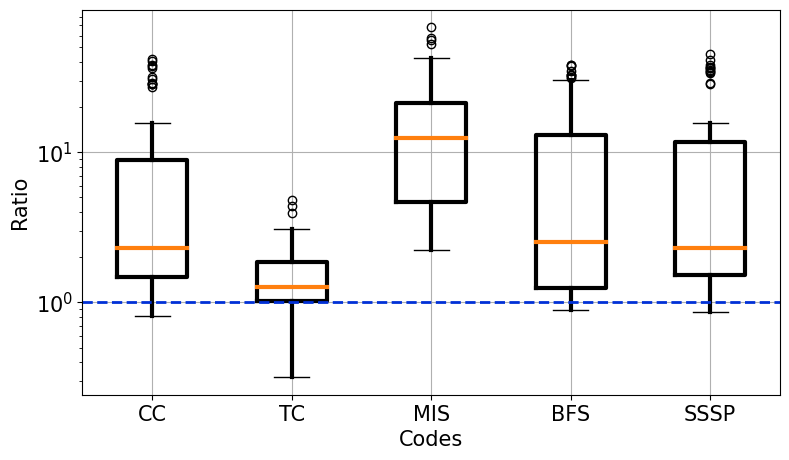

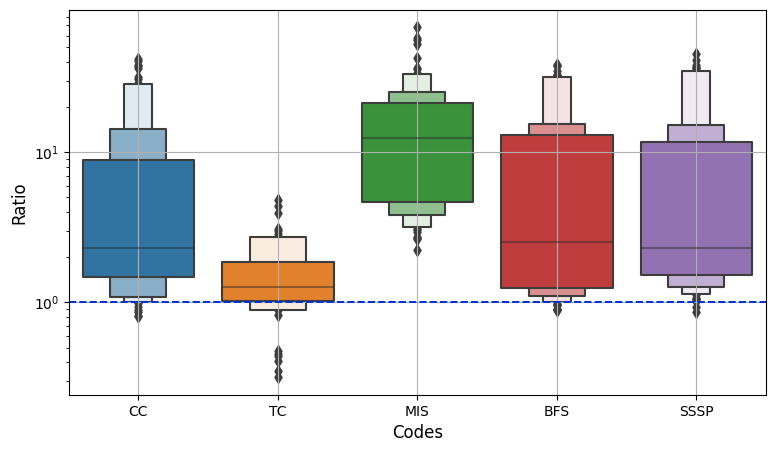

In [20]:
plot_ratio(['cc', 'tc', 'mis', 'bfs', 'sssp'], ['_all'], ['_V', '_E'], [cc_cpp, tc_cpp, mis_cpp, bfs_cpp, sssp_cpp], 'log', 'CPP')

all_C++


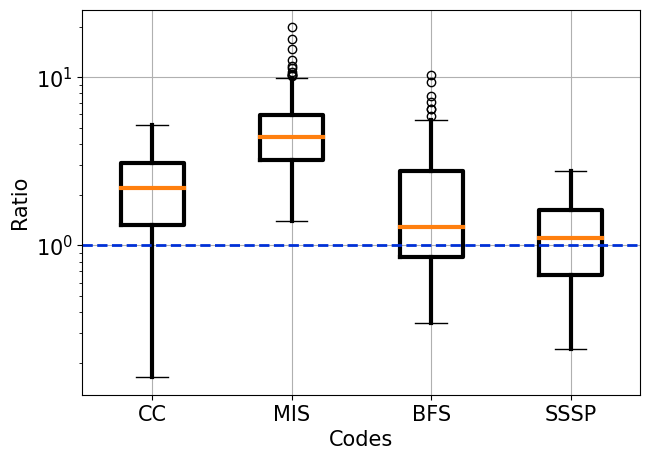

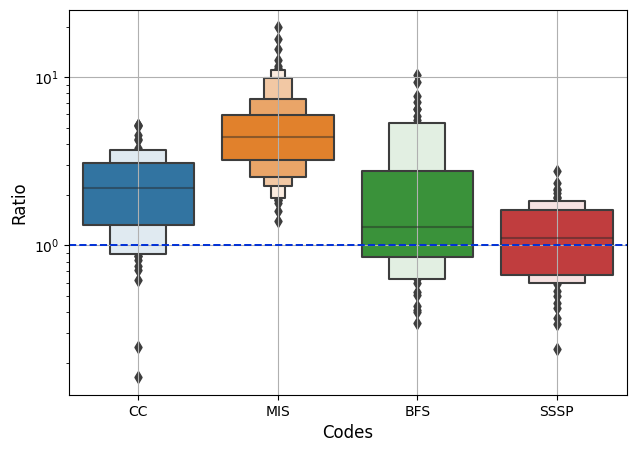

In [21]:
plot_ratio(['cc', 'mis', 'bfs', 'sssp'], ['_all'], ['_Topo', '_NonDup'], [cc_cpp, mis_cpp, bfs_cpp, sssp_cpp], 'log', 'C++')

all_C++


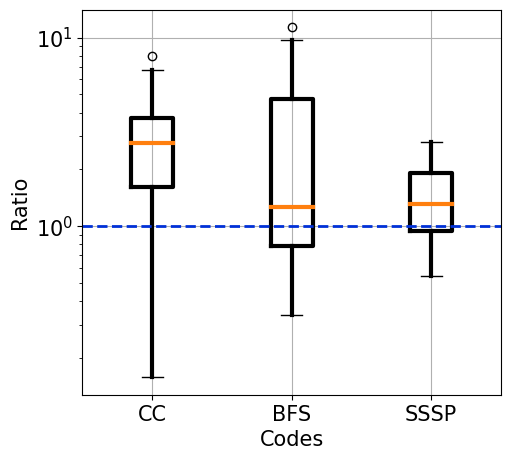

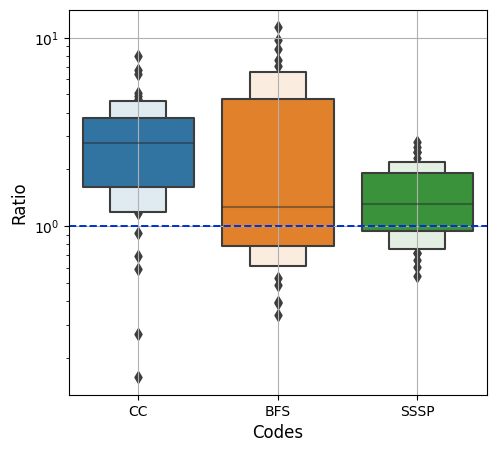

In [22]:
plot_ratio(['cc', 'bfs', 'sssp'], ['_all'], ['_Topo', '_Dup'], [cc_cpp, bfs_cpp, sssp_cpp], 'log', 'C++')

all_CPP


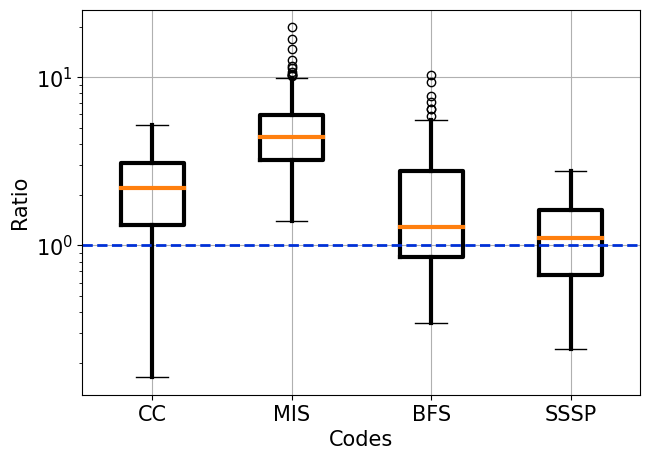

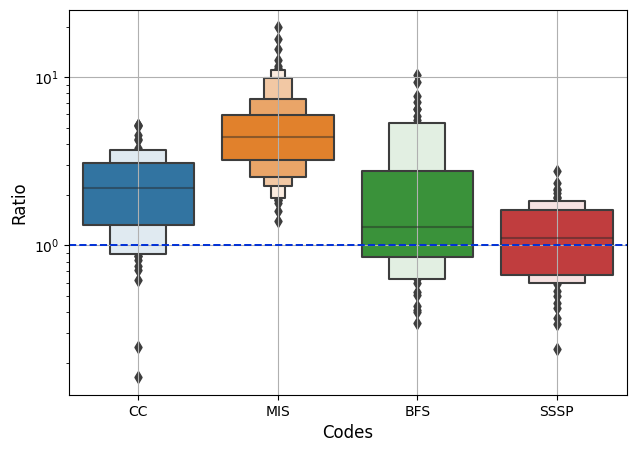

In [23]:
plot_ratio(['cc', 'mis', 'bfs', 'sssp'], ['_all'], ['_Topo', '_NonDup'], [cc_cpp, mis_cpp, bfs_cpp, sssp_cpp], 'log', 'CPP')

all_CPP


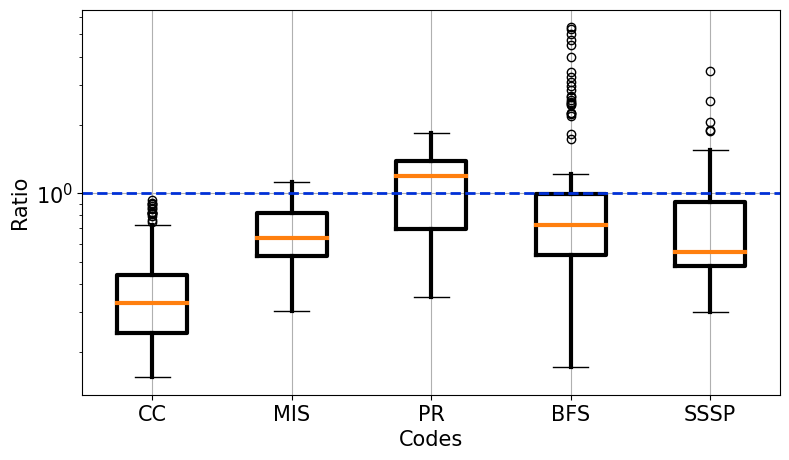

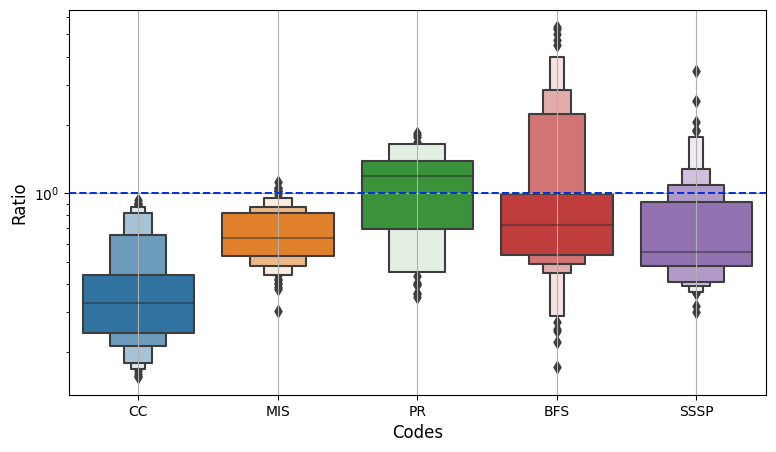

In [24]:
plot_ratio(['cc', 'mis', 'pr', 'bfs', 'sssp'], ['_all'], ['_Determ', '_NonDeterm'], [cc_cpp, mis_cpp, pr_cpp, bfs_cpp, sssp_cpp], 'log', 'CPP')

all_CPU


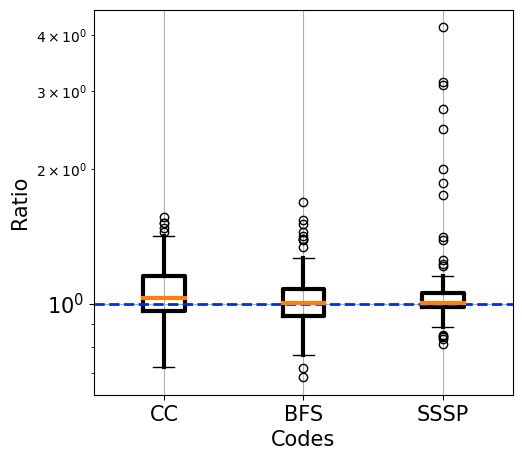

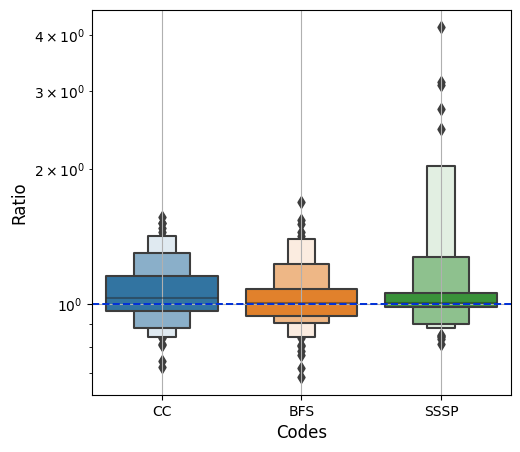

In [25]:

plot_ratio(['cc', 'bfs', 'sssp'], ['_all'], ['_ReadWrite', '_ReadModifyWrite'], [cc_cpp, bfs_cpp, sssp_cpp], 'log', 'CPU')

all_C++ Threads


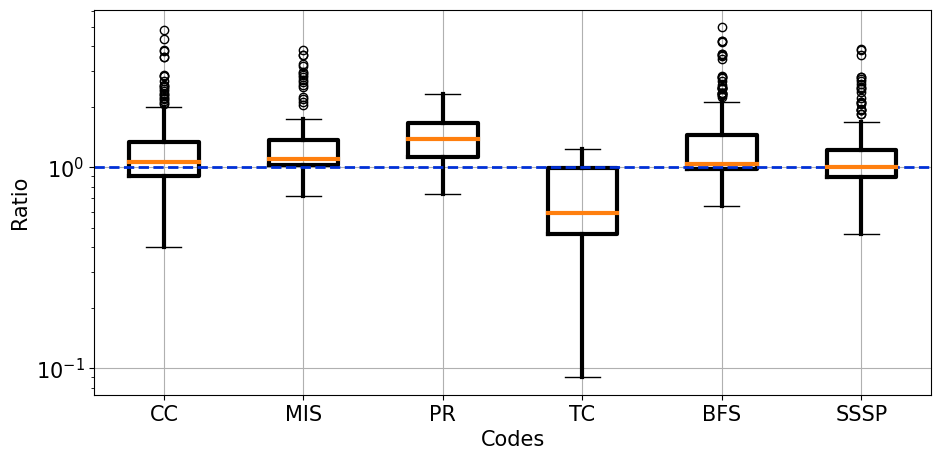

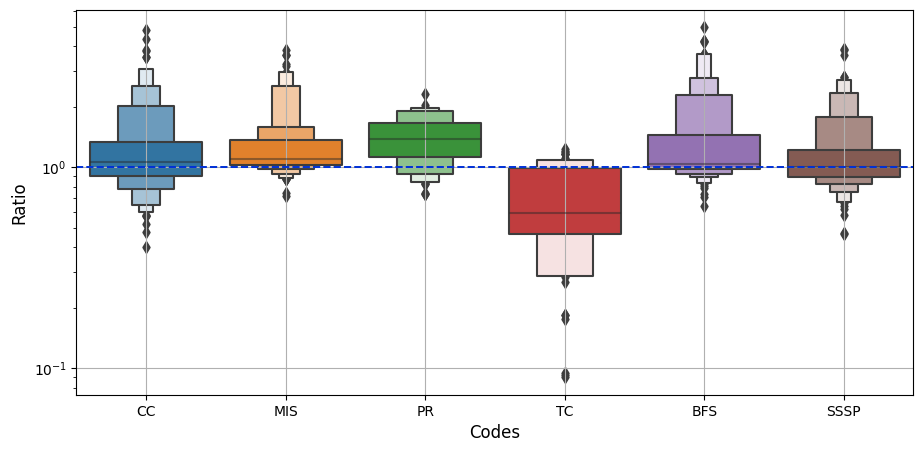

In [26]:
plot_ratio(['cc', 'mis', 'pr', 'tc', 'bfs', 'sssp'], ['_all'], ['_Block', '_Cyclic'], [cc_cpp, mis_cpp, pr_cpp, tc_cpp, bfs_cpp, sssp_cpp], 'log', 'C++ Threads')

all_OpenMP


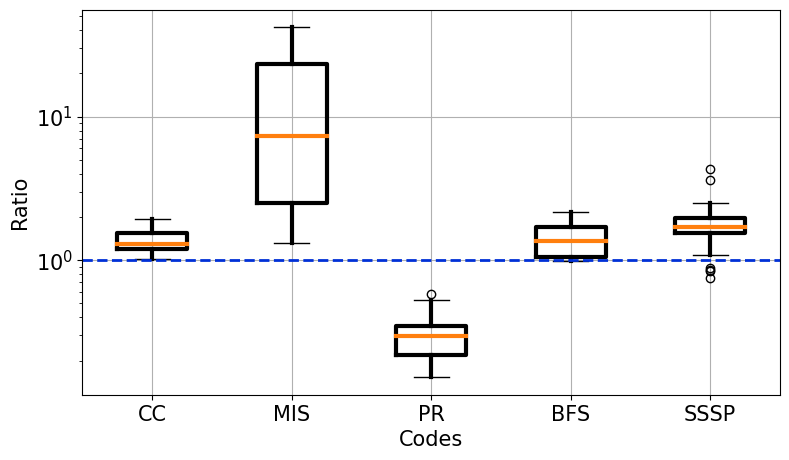

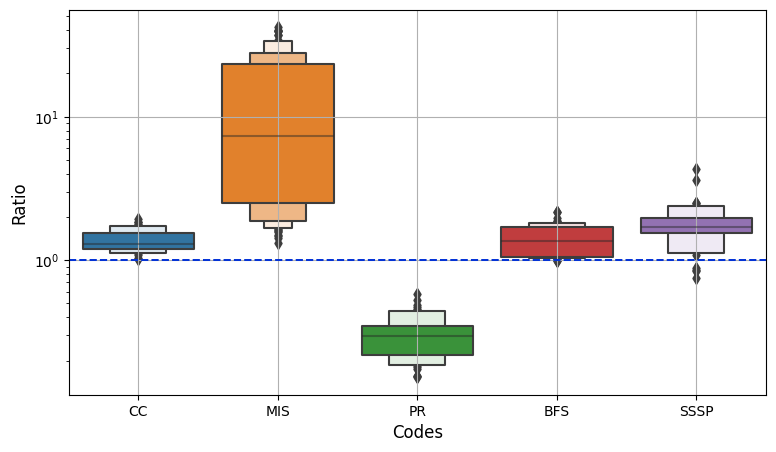

In [27]:
plot_ratio(['cc', 'mis', 'pr', 'bfs', 'sssp'], ['_all'], ['_Push', '_Pull'], [cc_cpp, mis_cpp, pr_cpp, bfs_cpp, sssp_cpp], 'log', 'OpenMP')